Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Default title text
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Code excerpts from the flood forecasting inundation models

These code excerpts are shared as part of the "*Flood forecasting with machine learning models in an operational framework*" paper, and describe the inundation modelling algorithms as were used by the flood forecasting operational framework during 2021.

The first few sections of this colab define some dummy Digital Elevation Map (DEM) and some dummy inundation maps. This dummy dataset is later used as test code, and allows the readers to see the algorithmic code in action.

After the definition of the dummy dataset, one can find the code for the *Thresholding Model* and the *Manifold Model* as described in the paper. For every model there is a short passage of test code that uses the dummy dataset in order to show the code in action.

# Dummy Dataset

Here we define the dummy DEM and some dummy inundation maps. Note that the inundation maps match lower areas in the DEM, plus some random noise, in order to be closer to realistic scenarios. 

In [2]:
from typing import Optional, Sequence, Tuple
from matplotlib import pyplot as plt
import numpy as np
import dataclasses


# Stores the ground truth image with the corresponding gauge measurement.
@dataclasses.dataclass
class GroundTruthMeasurement:
  # The ground truth inundation map.
  ground_truth: np.ma.MaskedArray
  # The corresponding gauge measurement.
  gauge_measurement: float

### Create the dummy DEM

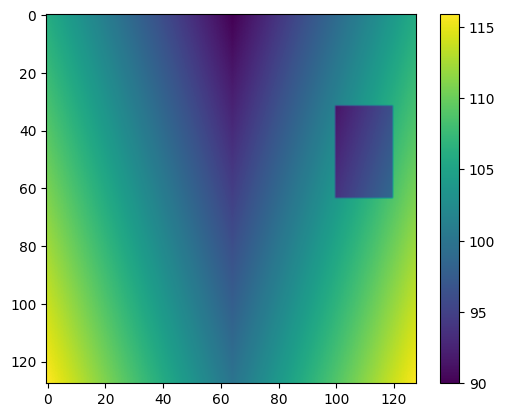

In [3]:
DEM = np.tile(np.abs(np.arange(-16, 16, step=0.25)), (128, 1)) + 100
DEM = DEM - np.tile(np.arange(10, 0, step=-10/128), (128, 1)).T
DEM[32:64, 100:120] -= 10
plt.imshow(DEM)
plt.colorbar();

In [4]:
DEM

array([[106.      , 105.75    , 105.5     , ..., 105.25    , 105.5     ,
        105.75    ],
       [106.078125, 105.828125, 105.578125, ..., 105.328125, 105.578125,
        105.828125],
       [106.15625 , 105.90625 , 105.65625 , ..., 105.40625 , 105.65625 ,
        105.90625 ],
       ...,
       [115.765625, 115.515625, 115.265625, ..., 115.015625, 115.265625,
        115.515625],
       [115.84375 , 115.59375 , 115.34375 , ..., 115.09375 , 115.34375 ,
        115.59375 ],
       [115.921875, 115.671875, 115.421875, ..., 115.171875, 115.421875,
        115.671875]])

## Create the dummy inundation maps

In [4]:
def river_with_length(length):
    first_row = np.zeros(128)
    first_row[64-length:64+length] = True
    imap = np.tile(first_row, (128, 1)).astype(bool)

    # Add some random noise so things will be slightly more interesting.
    random_mask = np.random.rand(128, 128) > 0.95
    imap ^= random_mask

    return np.ma.masked_array(imap)

GROUND_TRUTH = [
    GroundTruthMeasurement(
        ground_truth=river_with_length(3),
        gauge_measurement=1
    ),
    GroundTruthMeasurement(
        ground_truth=river_with_length(10),
        gauge_measurement=2
    ),
    GroundTruthMeasurement(
        ground_truth=river_with_length(20),
        gauge_measurement=3
    )
]

In [6]:
GROUND_TRUTH[0]

GroundTruthMeasurement(ground_truth=masked_array(
  data=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  mask=False,
  fill_value=True), gauge_measurement=1)

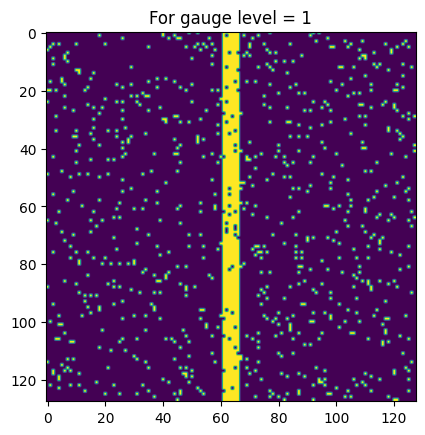

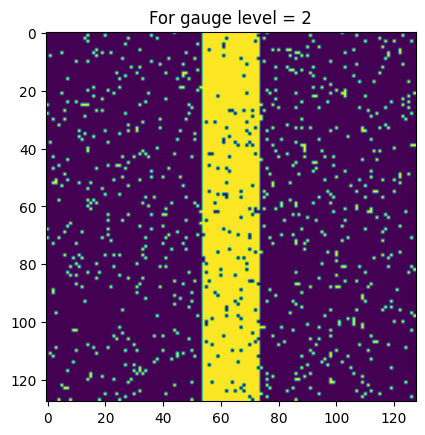

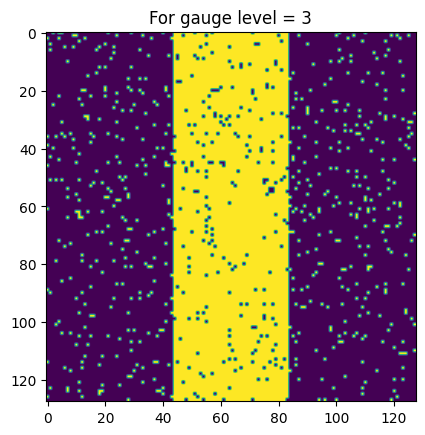

In [5]:
for gt in GROUND_TRUTH:
    plt.imshow(gt.ground_truth)
    plt.title(f'For gauge level = {gt.gauge_measurement}')
    plt.show()

# Thresholding Model

Below is the code for the *Thresholding model* as described in the paper.

## Thresholding model code

In [6]:
"""Library functions for predicting flood extent based on historical data."""
from typing import Optional, Sequence, Tuple

from absl import logging  # noqa: E402
import numpy as np  # noqa: E402

# Range above heighest measurement and below lowest measurement in which we
# expect to get measurements.
_MEASUREMENT_BUFFER_METERS = 10

# A number that is smaller than the uncertainty bound of a gauge measurement.
_EPSILON = 0.002


def get_cutoff_points(
    measurements: np.ndarray,
    precision_oriented: bool) -> Tuple[Sequence[int], np.ndarray]:
  """Gets all valid cutoff points and threshold values.

  A cutoff point is the index of a measurement at which we can separate lower
  measurements from higher measurements. For a cutoff point i, the matching
  threshold value must be greater or equal to measurement[i-1] and less than
  measurement[i]. Thus, the i'th event is the first wet event.

  The corresponding threshold value is a gauge measurement value which separates
  examples up to the given cutoff from those above the given cutoff.

  Args:
    measurements: All obtained measurements in the training set, sorted in
      ascending order.
    precision_oriented: if true, select the i'th cutoff to be measurements[i] -
      _EPSILON, otherwise the i'th cutoff is measurements[i-1]

  Raises:
    ValueError: If measurements are not sorted.

  Returns:
    cutoff_points: Indices at which there exists a threshold which separates
      between positive and negative measurements. The length of the list is the
      number of distinct measurements plus 1.
    threshold_values: Gauge measurement values which separate at those cutoffs.
      Shape is (num_cutoffs,).
  """
  # `measurements` is sorted in ascending order. Let's just verify this.
  if np.any(np.diff(measurements) < 0):
    raise ValueError('Expected measurements to be sorted: %r' % measurements)

  # Add an artificially low threshold value, to be used for pixels which should
  # always be wet.
  threshold_values = [measurements[0] - _MEASUREMENT_BUFFER_METERS]
  cutoff_points = [0]

  differing_measurements = ~np.isclose(measurements[:-1], measurements[1:])
  differing_locations = np.nonzero(differing_measurements)[0]
  cutoff_points.extend(differing_locations + 1)
  # For cutoffs higher than the lowest event and lower than the highest event,
  # any threshold value between measurements[i] and measurements[i+1] can be
  # used.
  if precision_oriented:
    # To be as conservative as possible, we choose measurements[i+1] - _EPSILON,
    # in order to include as small a region as possible in the risk map.
    threshold_values.extend(measurements[differing_locations + 1] - _EPSILON)
  else:
    # To alert as much as possible, we choose measurements[i],
    # in order to include as large a region as possible in the risk map.
    threshold_values.extend(measurements[differing_locations])

  # Add the final threshold. When not precision oriented, above the highest
  # event all pixels should be considered inundated. When precision oriented,
  # above the inundation map should be equal to that of the highest event.
  threshold_values.append(measurements[-1])
  if precision_oriented:
    threshold_values[-1] += _MEASUREMENT_BUFFER_METERS
  cutoff_points.append(len(measurements))

  logging.info('Found %d threshold values: %r', len(threshold_values),
               np.asarray(threshold_values))

  return cutoff_points, np.asarray(threshold_values, dtype=float)


def _count_true_in_suffixes(imaps: np.ndarray,
                            cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of True's above the cutoff at each pixel.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples. For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is True above cutoff c.
  """
  all_count_true = np.nancumsum(imaps[::-1], axis=0)[::-1]
  # If the suffix is empty, the number of True's is zero.
  filler_zeros = np.expand_dims(np.zeros_like(all_count_true[0]), 0)
  all_count_true = np.concatenate([all_count_true, filler_zeros])
  return all_count_true.take(cutoff_points, axis=0, mode='clip')


def count_true_wets_per_cutoff(imaps: np.ndarray,
                               cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of wets observations of each pixel above each cutoff.

  Wet observations of a pixel above a given cutoff can be thought of as "true
  wet" decisions for that cutoff value.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples. For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is wet above cutoff c.
  """
  return _count_true_in_suffixes(imaps, cutoff_points)


def count_false_wets_per_cutoff(imaps: np.ndarray,
                                cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of dry observations of each pixel above each cutoff.

  Dry observations of a pixel above a given cutoff can be thought of as "false
  wet" decisions for that cutoff value.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples. For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is wet below cutoff c.
  """
  not_imaps = 1 - imaps
  return _count_true_in_suffixes(not_imaps, cutoff_points)


def count_false_drys_per_cutoff(imaps: np.ndarray,
                                cutoff_points: Sequence[int]) -> np.ndarray:
  """Returns the number of wet observations of each pixel below each cutoff.

  Wet observations of a pixel below a given cutoff can be thought of as "false
  dry" decisions for that cutoff value.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width)
      for 3d arrays, or (num_train_examples,) for 1d arrays.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.

  Returns:
    Array with the same shape as imaps, where the first axis has shape
    num_cutoffs instead of num_train_examples .For example, if imaps is an array
    with shape (num_train_examples, height, width), the result is an array with
    shape (num_cutoffs, height, width) whose [c,i,j] element is the number of
    events whose pixel [i,j] is dry above cutoff c.
  """
  all_count_false_drys = np.nancumsum(imaps, axis=0)
  # If the cutoff is lower than all events, the number of false drys is zero.
  filler_zeros = np.expand_dims(np.zeros_like(all_count_false_drys[0]), 0)
  all_count_false_drys = np.concatenate([filler_zeros, all_count_false_drys])
  return all_count_false_drys.take(cutoff_points, axis=0, mode='clip')


def _get_pixel_threshold_index(pixel_events: np.ndarray,
                               cutoff_points: np.ndarray,
                               min_ratio: float) -> int:
  """Calculates the threshold index in cutoff_points for a single pixel.

  Args:
    pixel_events: 1D array of the inundation at the pixel for all events, by
      increasing gauge order.
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.
    min_ratio: Select the threshold at each pixel such that the ratio between
      added true positives and added false positives is above min_ratio.

  Returns:
    Index within cutoff_points of the threshold of the given pixel.
  """
  while np.nansum(pixel_events):
    true_wets = count_true_wets_per_cutoff(pixel_events, cutoff_points)
    false_wets = count_false_wets_per_cutoff(pixel_events, cutoff_points)
    ratios = true_wets / false_wets
    # The empty slice, corresponding to ratios[-1], has 0 true wets and 0 false
    # wets. We define the ratio there to be 0, as we want any slice that
    # contain a true wet to have a higher ratio than the empty slice.
    ratios[-1] = 0
    # Take the last maximum. In the case we have d, nan, w, we want the
    # threshold to be between nan and w, despite the fact that the threshold
    # between d and nan has the same ratio.
    best_index = ratios.shape[0] - 1 - np.nanargmax(ratios[::-1])

    if ratios[best_index] < min_ratio:
      break
    # Find the next candidate threshold on the prefix of all events below the
    # current best cutoff point.
    best_cutoff_point = cutoff_points[best_index]
    pixel_events = pixel_events[:best_cutoff_point]
    cutoff_points = cutoff_points[:best_index + 1]
  # If the remaining slice contains only NaNs, pixel should always be
  # inundated.
  if np.all(np.isnan(pixel_events)):
    return 0
  return len(cutoff_points) - 1


def _get_threshold_indices(imaps: np.ndarray, cutoff_points: np.ndarray,
                           min_ratio: float) -> np.ndarray:
  """Calculates the threshold index in cutoff_points for all pixels.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width).
    cutoff_points: Indices into the first axis of `imaps`, at which it is
      possible to separate between lower and higher flood events. This includes
      all indices except those having identical gauge measurements as the
      subsequent event.
    min_ratio: Select the threshold at each pixel such that the ratio between
      added true positives and added false positives is above min_ratio.

  Returns:
    threshold_indices: Array of threshold indices within cutoff_points for
      each pixel. Shape is (height, width).
  """
  threshold_indices = np.zeros_like(imaps[0, :, :], dtype=int)
  for idx_y in range(threshold_indices.shape[0]):
    for idx_x in range(threshold_indices.shape[1]):
      threshold_indices[idx_y, idx_x] = _get_pixel_threshold_index(
          imaps[:, idx_y, idx_x], cutoff_points, min_ratio)
  return threshold_indices


def _learn_optimal_sar_prediction_internal(imaps: np.ndarray,
                                           measurements: np.ndarray,
                                           min_ratio: float) -> np.ndarray:
  """A version of learn_sar_prediction without the external data structures.

  Selects the threshold such that the number of added true positives divided by
  the number of added false positives is at least min_ratio.

  Args:
    imaps: Observed inundation maps for all training set flood events, sorted by
      increasing gauge measurement. Shape is (num_train_examples,height,width).
    measurements: All obtained measurements in the training set, sorted in
      ascending order.
    min_ratio: Selects the threshold at each pixel such that the ratio between
      added true positives and added false positives is above min_ratio.

  Returns:
    Array of thresholds for each pixel. Shape is (height, width).
  """
  cutoff_points, threshold_values = get_cutoff_points(
      measurements, precision_oriented=True)

  threshold_indices = _get_threshold_indices(imaps, np.array(cutoff_points),
                                             min_ratio)
  thresholds = threshold_values[threshold_indices]

  if np.issubdtype(imaps.dtype, np.floating):
    # If all inundation maps are NaN for a given pixel, make the threshold for
    # that pixel a NaN as well. This occurs when the pixel is outside the
    # requested forecast_region.
    thresholds = np.where(np.all(np.isnan(imaps), axis=0), np.nan, thresholds)

  return thresholds


def masked_array_to_float_array(masked_array):
  float_array = np.array(masked_array, dtype=float)
  mask = np.ma.getmaskarray(masked_array)
  float_array[mask] = np.nan
  return float_array


def learn_optimal_sar_prediction_from_ground_truth(
    flood_events_train: Sequence[GroundTruthMeasurement],
    min_ratio: Optional[float] = None) -> np.ndarray:
  """Constructs a GaugeThresholdingModel based on historical observations.

  This finds the optimal thresholding model for a specific min ratio, as
  described in the paper.

  Args:
    flood_events_train: Sequence of GroundTruthMeasurement objects to be used
      as training set.
    min_ratio: float argument. If provided, selects the threshold at each pixel
      such that the ratio between added true positives and added false positives
      is above min_ratio.

  Returns:
    GaugeThresholdingModel proto containing the learned model. For the optimal
    thresholding model only one threshold is learned, so the high, medium and
    low risk thresholds of the model are identical.
  """

  # shape=(num_train_examples, height, width)
  imaps = np.asarray([
      masked_array_to_float_array(fe.ground_truth) for fe in flood_events_train
  ])

  # shape=(num_train_examples,)
  measurements = np.asarray(
      [fe.gauge_measurement for fe in flood_events_train])
  return _learn_optimal_sar_prediction_internal(imaps, measurements,
                                                      min_ratio)

### Optimal min_ratio code

In [7]:
MIN_RATIOS = [0.1, 0.3, 0.5, 1, 2, 5, 10, 15, 20]

class ThresholdingModel:

    def f1_metric(self, ground_truths: Sequence[GroundTruthMeasurement],
                  thresholds: np.ndarray) -> float:
        """Returns the aggregated F1 metric for a set of thresholds."""
        relevant_true = predicted_true = true_positives = 0
        for gt in ground_truths:
            predicted = thresholds < gt.gauge_measurement
            actual = gt.ground_truth.astype(bool)
            true_positives += np.sum(predicted & actual)
            predicted_true += np.sum(predicted)
            relevant_true += np.sum(actual)
        
        total_precision = true_positives / predicted_true
        total_recall = true_positives / relevant_true
        return 2/(1/total_precision + 1/total_recall)

    def train(self, ground_truth: Sequence[GroundTruthMeasurement]):
        """Trains the model according to the provided training set."""
        min_ratio_to_thresholds = {}
        f1_to_min_ratio = {}
        for min_ratio in MIN_RATIOS:
            min_ratio_to_thresholds[min_ratio] = (
                learn_optimal_sar_prediction_from_ground_truth(GROUND_TRUTH, 
                                                               min_ratio))
            f1 = self.f1_metric(ground_truth, 
                                min_ratio_to_thresholds[min_ratio])
            print(f'For min_ratio={min_ratio} we get f1={f1}')
            f1_to_min_ratio[f1] = min_ratio
        
        best_f1 = max(f1_to_min_ratio.keys())
        best_min_ratio = f1_to_min_ratio[best_f1]
        print('chosen min_ratio', best_min_ratio)
        self.thresholds = min_ratio_to_thresholds[best_min_ratio]
    
    def infer(self, gauge_level: float):
        """Returns the inferred inundation model for a gauge level."""
        return self.thresholds < gauge_level

## Test code with dummy dataset

In [8]:
#@title train over dummy dataset
tm = ThresholdingModel()
tm.train(GROUND_TRUTH)

C:\Users\tsiokano\AppData\Local\Temp\ipykernel_12452\1027469096.py:213: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
C:\Users\tsiokano\AppData\Local\Temp\ipykernel_12452\1027469096.py:213: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.9175276584072414
For min_ratio=0.3 we get f1=0.9175276584072414
For min_ratio=0.5 we get f1=0.9175276584072414
For min_ratio=1 we get f1=0.9359175662414132
For min_ratio=2 we get f1=0.9309214006135618
For min_ratio=5 we get f1=0.926336061627347
For min_ratio=10 we get f1=0.926336061627347
For min_ratio=15 we get f1=0.926336061627347
For min_ratio=20 we get f1=0.926336061627347
chosen min_ratio 1


### Inference examples

The thresholding model has been trained on three inundation maps, corresponding to gauge levels of 1, 2 and 3. Below, one can see that the output for gauge levels of 2, 2.5, and 3.

It can be seen that for 1 and 1.5, the image is less noisy. This is due to the monotinization that is done by the model, since the model does not allow for a decrease in flood where the gauge level rises.

It can also be seen that the model is not able to interpolate between the images in the train set, as expected.

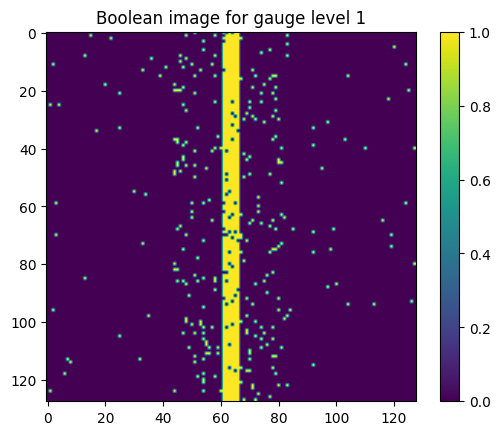

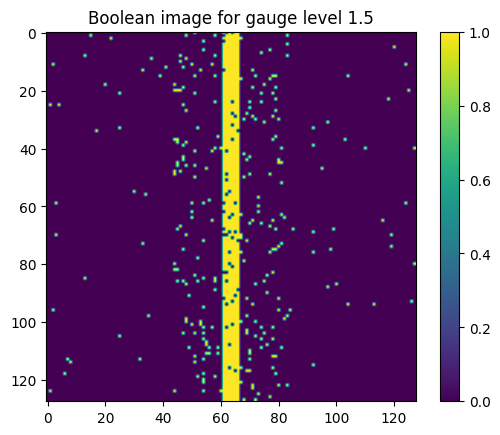

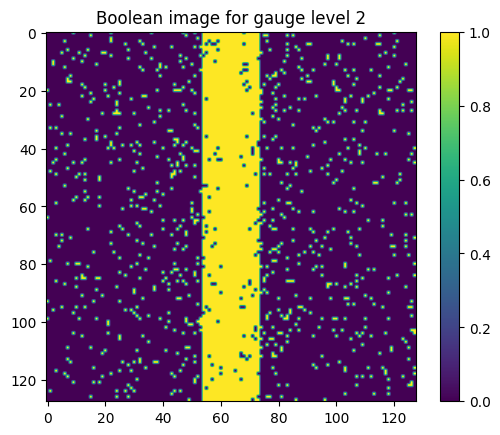

In [9]:
for gauge_level in [1, 1.5, 2]:
    plt.title(f'Boolean image for gauge level {gauge_level}')
    plt.imshow(tm.infer(gauge_level))
    plt.colorbar()
    plt.show()

# Manifold Model

Below is the *Manifold model* code, as descirbed in the paper. The code is split into two parts: first is the *Flood extent to depth* algorithm, which is proceeded by the *Manifold model* code.

In [10]:
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
import abc
import dataclasses
from typing import List, Optional, Sequence, Tuple

from absl import logging
import cv2
import numpy as np
import scipy
import skimage
import skimage.measure
import skimage.morphology

## Flood Extent to Depth code

In [12]:
"""A Laplace-equation solver for water depth based on flood extent image.

The module entry point is the laplace_depth_solve function, which runs the
laplace solve algorithm and returns the output water height raster. To run it,
one must use the LaplaceDepthSolverConfig dataclass, which holds the solver
configurations.
"""

def down_scale(raster: np.ndarray, down_scale_factor: int, 
               fraction: float = 0.1) -> np.ndarray:
  """Down scale a boolean raster image by down_scale_factor."""
  b = raster.shape[0] // down_scale_factor
  return raster.reshape(-1, down_scale_factor, b, down_scale_factor).mean(
      (-1, -3)) > fraction


class ForceCalculator(abc.ABC):
  """A generic interface for boundary conditions for a LaplaceDepthSolver."""

  @abc.abstractmethod
  def init_inundation_map(self, inundation_map: np.ma.MaskedArray,
                          down_scale_factor: int) -> np.ndarray:
    """A method for per-inundation map initializations.

    This function will be called by the `LaplaceDepthSolver.solve` function
    once, and before the `calc_foreces` function will be called. It is used to
    initialize internal data-structures that are inundation_map dependent.

    Args:
      inundation_map: The current inundation map. This inundation map will be
        saved internally and will be used by other methods.
      down_scale_factor: This constant implies the expected down-scale of the
        height_raster that will be passed to `calculate_forces`.

    Returns:
      boundary_force_indices: A numpy array of shape (N, 2), where N is the
        number of forces to be returned from the `calculate_forces` method. In
        this array, the i'th row represents the (x, y) coordinates of the i'th
        boundary force within the down scaled height raster.
    """
    pass

  @abc.abstractmethod
  def calculate_forces(self, height_raster: np.ndarray) -> np.ndarray:
    """A method for per-iteration calculation of the forces.

    This function will be called by the `LaplaceDepthSolver.solve` function at
    every round of the Laplace solver optimization process.

    Args:
      height_raster: The current height raster, on which the forces should be
        applied.

    Returns:
      An array of shape N with all the forces on the height_raster passed. The
      forces must be on a scale of the pixel-wise difference, where simply
      adding the forces to the height raster will satisfy all the conditions.
    """
    pass


def _find_contours(inundation_map: np.ndarray) -> Sequence[np.ndarray]:
  """Returns a list of all the contours in an inundation map.

  Args:
    inundation_map: A boolean numpy array representing an inundation map.

  Returns:
    A sequence of numpy arrays, each of shape (N_i, 2) where N_i is the length
    of the i'th contour. Each such numpy array represents the sequence of
    (x, y)'s of the contour. The contours are sorted from longest to shortest.
    Note that the contours are composed of pixels from the interior of the
    flooded region.
  """
  contours, _ = cv2.findContours(inundation_map.astype(np.uint8),
                                 mode=cv2.RETR_LIST,
                                 method=cv2.CHAIN_APPROX_NONE)
  contours = [contour[:, 0, ::-1] for contour in contours]
  return sorted(contours, key=lambda c: -c.shape[0])


def _mask_without_edge_pixels(masked_image: np.ma.MaskedArray) -> np.ndarray:
  """Returns the image mask where the pixels on the edge are masked too.

  The term "pixels on the edge" refers to pixels that are adjascent to either
  a masked pixel or a pixel that is out of image bounds.

  Args:
    masked_image: The image from which the pixels on the edge should be
      calculated.
  """
  mask = skimage.morphology.dilation(np.ma.getmaskarray(masked_image))
  mask[:, 0] = True
  mask[0, :] = True
  mask[:, -1] = True
  mask[-1, :] = True
  return mask


class CatScanForceCalculator(ForceCalculator):
  """A Force calculator class based on the cat-scan algorithm.

  For every flood-bounndary (contour) pixel, the force-calculator object finds
  the water height that generates the best inundation map in the neighborhood of
  the pixel. The forces generated by this object are the difference between the
  current water level and the water level that will generate an inundation map
  that is similar to the known inundation map at the neighborhood of that pixel.

  For more details about the Catscan algorithm, refer to the `_catscan` function
  documentation.
  """

  _dem: np.ndarray
  _local_region_width: int
  _tolerance: int
  _thresholds: Sequence[float]
  _catscan_result: np.ndarray
  _boundary_condition_min: np.ndarray
  _boundary_condition_max: np.ndarray
  _boundary_condition_weight: np.ndarray
  _scaled_boundary_condition_indices: np.ndarray

  # The step (in meters) between two consecutive catscan iterations.
  _CATSCAN_RESOLUTION: float = 0.1

  def __init__(self, dem: np.ndarray, local_region_width: int, tolerance: int):
    """Initializes the CatScanForceCalculator object.

    Args:
      dem: The DEM to use. Should be in the same scale of the ground truth
        images.
      local_region_width: The width (in pixels) of the region around a pixel
        in which the DEM is compared to the inundation map.
      tolerance: For every boundary pixel, the algorithm finds the gauge
        interval (i.e. min/max values) that generates an inundation map that
        best matches the local region of that pixel. The tolerance parameter
        sets how many pixels can an inundation map deviate from the inundation
        map that generates the best match, and still be counted good. For
        example, for a pixel (x, y) the following are the accuracy result within
        its local region: {69.8: 5,  69.9: 3, 70.0: 0, 70.1: 10}. If tolerance
        is 0, then the forces will pull towards 70.0, and if tolerance is 3, the
        forces will pull towards the interval (69.9, 70.0). For more
        information, refer to the documentation of `_catscan`.
    """
    self._dem = dem
    self._local_region_width = local_region_width
    self._tolerance = tolerance
    self._boundary_condition_min = np.array([])
    self._boundary_condition_max = np.array([])
    self._boundary_condition_weight = np.array([])
    self._scaled_boundary_condition_indices = np.array([[], []])

  def _catscan(self, inundation_map: np.ma.MaskedArray):
    """Performs the Catscan algorithm.

    For every possible water level, this method thresholds the DEM (i.e. creates
    a boolean image containing the result of (dem > water level)) and stores for
    every flood boundary pixel how much is the thresholded DEM similar to the
    flood pattern at the neighborhood area of thet pixel.
                                                                       y
    For example, the known inundation map at the local region       +-----+
    of a boundary pixel at coordinates (x, y) is shown in           | ****|
    Figure (a).                                                    x|   **|
                                                                    |    *|
    The Catscan algorithm thresholds the image at various           +-----+
    different levels, and for every speicifc pixel (x, y)          Figure (a)
    it records the difference (in pixels) of every thresholded
    image from the known inundation map at the local region of the pixel. An
    example can be seen in Figure (b) below.

    +-------------+------------------------------------------------------------+
    | Thresholds: |   3.0m      3.1m      3.2m      3.3m      3.4m      3.5m   |
    +-------------+------------------------------------------------------------+
    |             | +-----+   +-----+   +-----+   +-----+   +-----+   +-----+  |
    | Infered     | |    *|   |   **|   |  ***|   |  ***|   |*****|   |*****|  |
    | local       | |     |   |    *|   |    *|   |   **|   |  ***|   |*****|  |
    | images:     | |     |   |     |   |    *|   |    *|   |  ***|   | ****|  |
    |             | +-----+   +-----+   +-----+   +-----+   +-----+   +-----+  |
    +-------------+------------------------------------------------------------+
    | Difference: | 6 pixels  4 pixels  2 pixel   1 pixels  4 pixels  7 pixels |
    +-------------+------------------------------------------------------------+
                  Figure (b): Illustration of the Catscan algorithm
                      for a specific pixel on the boundary.

    Then, the algorithm finds for every pixel the threshold level that minimizes
    the difference. In our example, the level 3.3m minimizes the difference for
    pixel (x, y), and the minimum difference is 1 pixel.

    In addition, the algorithm finds the thresholds that are within distance
    of `tolerance` (parameter to the `__init__` function) pixels from the
    minimum difference. Table (a) shows the minimum/maximum values for pixel
    (x, y) for various values of `tolerance` configuration.

               +------------+-----------------+-----------------+
               | Tolerance  |  Pixel minimum  |  Pixel maximum  |
               +------------+-----------------+-----------------+
               |  0 pixels  |       3.3m      |        3.3m     |
               |  2 piexls  |       3.2m      |        3.3m     |
               |  4 pixels  |       3.1m      |        3.4m     |
               +------------+-----------------+-----------------+
                    Table (a) Illustraion of the `tolerance`
                       configuration for the pixel (x, y).

    These min/max values are stored and used to calucate the per pixel force,
    at the `calculate_forces` method. Eventually, the force at pixel (x, y) is
    the difference between its current level and the interval
    [min level, max level] calculated by the catscan algorithm.

    Args:
      inundation_map: The known inundation map used by the algorithm.
    """
    contours = _find_contours(np.ma.filled(inundation_map, False))
    local_region_area = self._local_region_width**2

    self.all_contours = np.concatenate(contours)
    contour_lengths = [contour.shape[0] for contour in contours]
    self.all_contours_start = np.cumsum([0] + contour_lengths)
    invalid = skimage.morphology.dilation(np.ma.getmaskarray(inundation_map))
    valid_dem_pixels = self._dem.copy()
    valid_dem_pixels[invalid] = np.nan

    # Find all the DEM values along the contours and store it in a 1D array.
    all_dem_pixels = valid_dem_pixels[self.all_contours[:, 0],
                                      self.all_contours[:, 1]]

    # Use it to find the minimum and maximum values for the scan.
    scan_min, scan_max = np.nanpercentile(all_dem_pixels, (1, 99))
    scan_min -= 2 * self._CATSCAN_RESOLUTION
    scan_max += 2 * self._CATSCAN_RESOLUTION
    self._thresholds = np.arange(scan_min, scan_max, self._CATSCAN_RESOLUTION)

    logging.info('Performing DEM catscan from %f to %f...', scan_min, scan_max)
    contours_difference_list = []
    for thresh in self._thresholds:
      thresholded = self._dem < thresh

      # Find the per-pixel difference between the thresholded image and the
      # inundation map image.
      difference_map = np.logical_xor(thresholded, inundation_map)

      # Use the blur function to set every pixel to be the average difference in
      # its local region of width self._local_region_width.
      block_difference = cv2.blur(
          difference_map.astype(np.uint8) * local_region_area,
          (self._local_region_width, self._local_region_width))

      # Find the block differences along the contour lines.
      contours_difference = block_difference[self.all_contours[:, 0],
                                             self.all_contours[:, 1]]
      contours_difference_list.append(contours_difference)

    self._catscan_result = np.array(contours_difference_list)

  def _get_boundary_levels(
      self,
      contour_index: Optional[int] = None
  ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Returns the min/max boundary levels for every boundary pixel.

    Args:
      contour_index: If passed, only pixels within this contour will be
        returned.

    Returns:
      Three 1D numpy arrays, all having shape (N,) where N is the number of
      pixels within the contour. The arrays are:
        boundary_min: The minimal threshold for every pixel which satisfies the
          DEM within `self._tolerance` pixels from the best matching threshold.
        boundary_max: The maximal threshold for every pixel which satisfies the
          DEM within `self._tolerance` pixels from the best matching threshold.
        weight: For every boundary pixel, returns how well does it match the
          DEM.
    """
    if contour_index is not None:
      contour_start = self.all_contours_start[contour_index]
      contour_end = self.all_contours_start[contour_index+1] - 1
      catscan_result = self._catscan_result[:, contour_start:contour_end]
    else:
      catscan_result = self._catscan_result

    # Calculate the weight of every pixel in a contour according to the minimum
    # difference between the known inundation map and the inundation map
    # generated by thresholding the DEM, at the local region of the pixel. This
    # number correspond to how well does the DEM matches the inundation map in
    # the neighborhood of that pixel.
    weight = 1 - catscan_result.min(axis=0) / (self._local_region_width**2)
    good_region = (
        catscan_result <= catscan_result.min(axis=0) + self._tolerance)
    good_min_index = np.argmax(good_region, axis=0)
    good_max_index = good_region.shape[0] - np.argmax(
        good_region[::-1, :], axis=0) - 1

    boundary_min = self._thresholds[good_min_index]
    boundary_max = self._thresholds[good_max_index]
    return boundary_min, boundary_max, weight

  def init_inundation_map(
      self, inundation_map: np.ma.MaskedArray,
      down_scale_factor: int) -> Tuple[np.ndarray, np.ndarray]:
    self._catscan(inundation_map)
    min_height = np.zeros_like(self._dem)
    max_height = np.zeros_like(self._dem)
    weight = np.zeros_like(self._dem)

    contours_min, contours_max, contours_weights = self._get_boundary_levels()
    min_height[self.all_contours[:, 0], self.all_contours[:, 1]] = contours_min
    max_height[self.all_contours[:, 0], self.all_contours[:, 1]] = contours_max
    weight[self.all_contours[:, 0], self.all_contours[:, 1]] = contours_weights

    boundary_condition_mask = (min_height > 0)

    boundary_condition_mask[_mask_without_edge_pixels(inundation_map)] = False
    self._boundary_condition_min = min_height[boundary_condition_mask]
    self._boundary_condition_max = max_height[boundary_condition_mask]
    self._boundary_condition_weight = weight[boundary_condition_mask]
    boundary_condition_indices = np.argwhere(boundary_condition_mask)
    self._scaled_boundary_condition_indices = (
        boundary_condition_indices // down_scale_factor)

    return self._scaled_boundary_condition_indices.copy()

  def calculate_forces(self, height_raster):
    values = height_raster[self._scaled_boundary_condition_indices[:, 0],
                           self._scaled_boundary_condition_indices[:, 1]]

    down_forces = np.clip(
        self._boundary_condition_min - values, a_min=0, a_max=None)
    up_forces = np.clip(
        values - self._boundary_condition_max, a_min=0, a_max=None)
    force = (down_forces - up_forces) * self._boundary_condition_weight
    force[np.isnan(force)] = 0.
    return force


@dataclasses.dataclass(frozen=True)
class LaplaceDepthSolverConfig:
  """Holds the configuration for the LaplaceDepthSolver object.

  Attributes:
    down_scale_factor: The down scale factor to be used for the result water
      height raster. For example: If the inundation map is of scale 1000x2000
      and down_scale_factor=10, the result height raster will be of shape of
      100x200. This factor directly controls the high frequency smoothness,
      where the larger it is, the smoother the output is.
    solve_iterations_factor: A factor that controls the number of iterations to
      be done by the solver in order to reach convergence. The factor represents
      the ratio between the length (in pixels) of the diagonal of the output
      height raster and the number of iterations. For example: If the height
      raster is 300x400 pixels, and solve_iterations_factor is 3 then the total
      number of iterations will be 3 * 500 = 1500.
    force_coeff: How strongly do the boundary forces affect the output height
      raster. If force_coeff=1, then all the boundary conditions must be met by
      the output height raster no matter how strong deformations are caused. If
      force_coeff=0 then all the boundary conditions are completely ignored, and
      the output height raster will be constant. A value within the interval
      (0, 1) will allow different smoothness/boundary conditions tradeoff.
    drop_iterations: How many drop iterations should be made by the solver. At
      every drop iteration, the solver reaches convergence and produces a
      height_raster, where between different such drop iterations, the solver
      drops `drop_coeff` of the forces.
    drop_coeff: Share of forces to be ignored between two consecutive drop
      iterations. For example, if `drop_iterations`=2 and `drop_coeff`=0.05,
      then the solver will:
      1. Solve the equation using all the boundary forces.
      2. Drop 5% largest forces.
      3. Solve the equation again with the rest of the forces.
  """

  down_scale_factor: int
  solve_iterations_factor: float
  force_coeff: float
  drop_iterations: int
  drop_coeff: float


def shift_array(array: np.ndarray, shift: int, axis: int) -> np.ndarray:
  """Shift a numpy array by a constant amount on a specified axis."""
  shifted_array = np.zeros_like(array)
  array = np.asarray(array)

  def slice_axis(start, stop):
    return tuple(slice(start, stop) if curr_axis == axis else slice(None)
                 for curr_axis in range(len(array.shape)))

  if shift == 0:
    return array[:]
  elif shift > 0:
    shifted_array[slice_axis(shift, None)] = array[slice_axis(0, -shift)]
  elif shift < 0:
    shifted_array[slice_axis(0, shift)] = array[slice_axis(-shift, None)]
  return shifted_array


class _LaplaceDepthSolver:
  """Helper class for solving the Laplace equation.

  For more information, see the `laplace_depth_solve` function.
  """

  _force_calculator: ForceCalculator
  _neighbours: List[Tuple[int, int]]
  _conf: LaplaceDepthSolverConfig
  _total_neighbors: np.ndarray
  _ignore_raster_mask: np.ndarray
  _forces_indices: np.ndarray
  _forces_per_pixel_raster: np.ndarray
  _forces_per_pixel_raster: np.ndarray
  _ignore_force_mask: np.ndarray

  # During the optimization, every pixels is replaced with the average of its
  # neighbors. This array defines the neighbors of every pixel, in (x,y) offsets
  # from the current pixel at index (0, 0).
  _PIXEL_NEIGHBOURS = ((0, 1), (0, -1), (1, 1), (1, -1), (0, 0))

  def __init__(self, force_calculator: ForceCalculator,
               config: LaplaceDepthSolverConfig):
    self._force_calculator = force_calculator
    self._config = config

  def _solve_iterations(self, raster: np.ndarray) -> int:
    """Returns the number of iterations needed for convergence.

    See `LaplaceDepthSolverConfig.solve_iterations_factor` for more details.

    Args:
      raster: The raster used by the solver.
    """
    diagonal_length = np.linalg.norm(raster.shape)
    return int(self._config.solve_iterations_factor * diagonal_length)

  def _init_laplace_step(self, solve_mask: np.ndarray) -> None:
    """Initializes attributes for the `self._laplace_step` method."""
    self._total_neighbors = np.zeros_like(solve_mask, dtype=int)
    for shift_axis, shift_amount in self._PIXEL_NEIGHBOURS:
      shifted_mask = shift_array(solve_mask, shift_amount, shift_axis)
      self._total_neighbors += shifted_mask

    self._total_neighbors[self._total_neighbors == 0] = -1.
    self._ignore_raster_mask = np.logical_not(solve_mask)

  def _laplace_step(self, height_raster: np.ndarray) -> np.ndarray:
    """Runs one Laplace gradient step.

    Returns a copy of the input array, where every pixel is replaced with the
    value of its neighbours.

    Args:
      height_raster: The input 2D array, with the same shape as `solve_mask`.

    Returns:
      A new array where every value is the average of its neighbours. The
      neighbours are only taken from within the solve_mask.
    """
    neighbours_sum = np.zeros_like(height_raster)
    for shift_axis, shift_amount in self._PIXEL_NEIGHBOURS:
      neighbours_sum += shift_array(height_raster, shift_amount, shift_axis)
    return neighbours_sum / self._total_neighbors

  def _init_force_step(self, inundation_map: np.ma.MaskedArray) -> np.ndarray:
    """Initializes attributes for the `self._force_step` method.

    Args:
      inundation_map: The inundation map to initialize.

    Returns:
      The initial guess for the height_raster, in the shape of the down sampled
      inundation map.
    """

    # initialize the force_calculator with the inundation_map
    self._forces_indices = self._force_calculator.init_inundation_map(
        inundation_map, self._config.down_scale_factor)

    # Set the initial guess to be the average force.
    init_height_raster = np.ma.filled(
        np.zeros_like(
            down_scale(inundation_map, self._config.down_scale_factor),
            dtype=float), 0.)
    forces = self._force_calculator.calculate_forces(init_height_raster)
    init_height_raster = init_height_raster + np.average(forces)

    # Calculate the number of forces per (downscale) pixel.
    self._forces_per_pixel_raster = np.zeros_like(init_height_raster,
                                                  dtype=np.uint16)
    np.add.at(self._forces_per_pixel_raster,
              (self._forces_indices[:, 0], self._forces_indices[:, 1]), 1)

    # Later on, the _forces_per_pixel is used as a denominator, where it is used
    # in order to calculate the average force per down-scaled pixel. To avoid
    # division by zero, and since the value of the average force in pixel that
    # has no forces at all should be 0, set all the 0 values to 1.
    self._forces_per_pixel_raster[self._forces_per_pixel_raster == 0] = 1

    # Initialize the _ignore_force_mask attribute.
    force = self._force_calculator.calculate_forces(init_height_raster)
    self._ignore_force_mask = np.zeros_like(force, dtype=bool)
    return init_height_raster

  def _force_step(self, height_raster: np.ndarray) -> np.ndarray:
    """Applies forces on the inundation map.

    The forces are calculated by `self._force_calculator`. The forces are
    applied at specific pixels, where the function deforms height_raster towards
    the forces. The deformation is controlled by `self._config.force_coeff`.

    Args:
      height_raster: The input 2D array on which to apply the forces.

    Returns:
      A deformation of height_raster towards the forces.
    """
    forces = self._force_calculator.calculate_forces(height_raster)
    forces[self._ignore_force_mask] = 0.

    force_raster = np.zeros_like(height_raster)
    np.add.at(force_raster,
              (self._forces_indices[:, 0], self._forces_indices[:, 1]),
              forces)
    height_raster += (
        force_raster / self._forces_per_pixel_raster * self._config.force_coeff)
    return height_raster

  def _run_laplace_convergence(self, height_raster: np.ndarray) -> np.ndarray:
    """Runs `self._solve_iterations()` of solve steps.

    Every solve step is a combination of laplace gradient update (implemented in
    _laplace_step method) followed by a boundary force update.

    Args:
      height_raster: The initial guess of the height raster.

    Returns:
      The result height_raster.
    """
    solve_iterations = self._solve_iterations(height_raster)

    for _ in range(solve_iterations):
      height_raster[self._ignore_raster_mask] = 0.
      height_raster = self._laplace_step(height_raster)
      height_raster = self._force_step(height_raster)

    return height_raster

  def _ignore_strong_forces(self, height_raster: np.ndarray) -> None:
    """Update self._ignore_force_mask with new strong forces.

    The forces that are ignored are taken to be `self._config.drop_coeff` of all
    the nonzero forces applied on the height raster.

    Args:
      height_raster: The height raster on which the forces are applied.
    """
    force_keep = 1. - self._config.drop_coeff
    forces = np.abs(self._force_calculator.calculate_forces(height_raster))
    forces[self._ignore_force_mask] = 0.

    nonzero_forces = forces[forces > 0.0001]
    strong_force_thresh = np.percentile(nonzero_forces, 100 * force_keep)
    logging.info('Ignoring all forces above %f.', strong_force_thresh)
    self._ignore_force_mask = np.logical_or(self._ignore_force_mask,
                                            forces > strong_force_thresh)

  def solve(self, inundation_map: np.ma.MaskedArray) -> np.ma.MaskedArray:
    """Given an inundation map, returns a water height raster.

    Args:
      inundation_map: The input inundation map. The inundation map is expected
        to be a 2D boolean masked array when masked vaules represent missing
        pixels.

    Returns:
      A 2D masked array, which has the same shape like a inundation_map, scaled
      down by `config.down_scale_factor`. Pixels that correspond to dry area in
      the input inundation map are masked out, where pixels that correspond to
      wet areas hold the water height above see level.
    """
    solve_mask = down_scale(
        inundation_map.filled(False), self._config.down_scale_factor)
    self._init_laplace_step(solve_mask)
    init_height_raster = self._init_force_step(inundation_map)

    height_raster = init_height_raster
    for drop_iter_index in range(self._config.drop_iterations):
      height_raster = self._run_laplace_convergence(height_raster)
      if drop_iter_index != self._config.drop_iterations - 1:
        self._ignore_strong_forces(height_raster)

    return np.ma.masked_array(height_raster, mask=np.logical_not(solve_mask))


def laplace_depth_solve(inundation_map: np.ma.MaskedArray,
                        force_calculator: ForceCalculator,
                        config: LaplaceDepthSolverConfig) -> np.ma.MaskedArray:
  """A solver for the 2D Laplace PDE over an arbitrary region.

  There are several features that this solver provides:
  1. It supports arbitrary boundary conditions by supporting a ForceCalculator
     object as the provider of the boundary forces.
  2. It allows solving the equation on a down-sampled version of the image, to
     allow for faster convergence and smoother outcome.
  3. It allows for ignoring outlier forces.

  The solver supports two different approaches for handling DEM/inundation map
  inconsistencies:
  1. Drop iterations: The solver supports running several drop iterations, where
     every such iteration consists of running the solver and reaching full
     convergence. Between two consecutive drop iterations, the solver throws
     `config.drop_coeff` share of largest non-zero forces. This allows throwing
     away outlier forces, and generating smoother (and more monotonic) water
     height raster.
  2. Boundary condition effectiveness: The solver uses the `config.force_coeff`
     to control how strongly does the boundary condition affect the output water
     height raster. Having force_coeff=1 will indicate that all the boundary
     conditions must be met, no matter how strong deformations are caused. Any
     value in the interval [0, 1) will make the solver prefer smoother output
     water height map over satisfying all the conditions.

  While both the above mechanisms serve the purpose of ignoring outlier boundary
  conditions, each does it in a different way, and has its own advantages and
  disadvantages. Hence, the user can decide which mechanism they prefer in the
  specific circumstance.

  This function only finds the water height within the wet pixels, where the
  water height in dry pixels is masked out.

  Args:
    inundation_map: The input inundation map. The inundation map is expected to
      be a 2D boolean masked array when masked values represent missing pixels.
    force_calculator: An subclass of ForceCalculator used for boundary
      conditions.
    config: An instance of LaplaceDepthSolverConfig holding all the
      configurations to be used in this run.

  Returns:
    A 2D masked array, which has the same shape like a inundation_map, scaled
    down by `config.down_scale_factor`. Pixels that correspond to dry area in
    the input inundation map are masked out, where pixels that correspond to wet
    areas hold the water height above see level.
  """
  lds = _LaplaceDepthSolver(force_calculator, config)
  return lds.solve(inundation_map)

In [13]:
"""Utilities for the flood extent to depth algorithm."""

from typing import Tuple

import cv2
import numpy as np
import PIL.Image
import scipy.ndimage
import skimage.morphology


# The minimimum size of a flooded components to be regarded by the
# flood_extent_to_depth algorithm. Smaller flooded components will be removed
# from the input inundation map.
_MIN_OBJECT_AREA_KM2 = 0.1


def clean_inundation_map(inundation_map: np.ma.MaskedArray,
                         scale_meters: float) -> np.ma.MaskedArray:
  """Removes small objects and holes from inundation map.

  Args:
    inundation_map: The inundation map to process, as a boolean 2D masked array.
    scale_meters: The inundation map scale, i.e. meters per pixel.

  Returns:
    A masked array representing the input inundation map without the small
    objects and holes.
  """
  min_object_area_pixels = 1000000 * _MIN_OBJECT_AREA_KM2 / scale_meters**2
  filtered_inundation_map = skimage.morphology.remove_small_objects(
      np.ma.filled(inundation_map.astype(bool), False),
      min_size=min_object_area_pixels)
  filtered_inundation_map = skimage.morphology.remove_small_holes(
      filtered_inundation_map,
      area_threshold=min_object_area_pixels)
  return np.ma.masked_where(np.isnan(inundation_map),
                            filtered_inundation_map)


def _nearest_neighbhor_interpolation(
    partial_image: np.ma.MaskedArray) -> Tuple[np.ndarray, np.ndarray]:
  """Interpolates a partial image to a full one using nearest neighbors.

  This function gets a partial 2D image, i.e. an image with missing pixels, and
  interpolates them according to the nearest neighbour algorithm, i.e. the value
  at a missing pixel is taken from its nearst valid pixel.

  Args:
    partial_image: A masked array, where missing pixels are masked out.

  Returns:
    full_image: The output interpolated image, that has no invalid pixels.
    interpolation_distance_pixels: A 2D numpy array with the same shape of the
      input image that holds for every pixel the distance (in pixels) to a
      known pixel.
  """
  edt_distances, edt_indices = scipy.ndimage.morphology.distance_transform_edt(
      input=np.ma.getmaskarray(partial_image),
      return_indices=True,
      return_distances=True)
  full_image = np.ma.getdata(partial_image)[edt_indices[0], edt_indices[1]]

  return full_image, edt_distances


def extend_height_raster(
    partial_height_raster: np.ma.MaskedArray, down_scale_factor: int,
    input_inundation_map: np.ma.MaskedArray,
    inundation_map_scale: int) -> Tuple[np.ndarray, np.ndarray]:
  """Extends a height raster to match valid pixels in the inundation map.

  Args:
    partial_height_raster: A masked array, where missing pixels are masked out.
    down_scale_factor: The ratio between the partial_height_raster scale to the
      input_inundation_map scale.
    input_inundation_map: The inundation map used to generate the
      partial_height_raster. It is used to determine which of the pixels of the
      output height_raster are valid.
    inundation_map_scale: The scale in meters of the input_inundation_map.

  Returns:
    height_raster: The output interpolated height raster, valid at the same
      pixels the input_inundation_map is valid.
    interpolation_distance: A 2D numpy array in the same shape of the
      height_raster that holds for every pixel the distance (in meters) to a
      known pixel.
  """

  # interpolate the height raster to the whole image.
  height_raster, interpolation_distance_pixels = (
      _nearest_neighbhor_interpolation(partial_height_raster))

  # Convert the interpolation_distance to be in meters rather than pixels.
  height_raster_scale = inundation_map_scale * down_scale_factor
  interpolation_distance = interpolation_distance_pixels * height_raster_scale

  # Invalidate pixels that are in an invalid part of the inundation map. Make
  # sure that no new invalid pixels are introduced due to the down scale by
  # invalidating a low-res pixel only if *all* the high-res pixels are invalid.
  fraction = 1 - 1 / down_scale_factor ** 2
  invalid_part = down_scale(
      np.ma.getmaskarray(input_inundation_map),
      down_scale_factor=down_scale_factor, fraction=fraction)
  height_raster[invalid_part] = np.nan

  return height_raster, interpolation_distance


def _keep_flooded_components(water_above_dem: np.ndarray,
                             known_inundation_map: np.ndarray,
                             agree_threshold: float) -> np.ndarray:
  """Given a possible inundation map, returns only the flooded component.

  Chooses only flooded compoenents from `water_above_dem` that agree with
  `known_inundation_map`.

  Args:
    water_above_dem: A boolean map that indicates for every pixel whether its
      calculated water height is above the DEM or below.
    known_inundation_map: An inundation map to be used as reference. The flooded
      components are chosen to be components that appear in this inundation map.
    agree_threshold: A number between 0 and 1 that indicates what is the
      minimum agreement ratio for a component to be chosen to be flooded.

  Returns:
    The output image containing only water_above_dem components that agree with
    known_inundation_map at at least `agree_threshold` of the pixels.
  """
  # water_above_dem_components indicates, for each pixel in water_above_dem,
  # the index of the connected component to which it belongs.
  water_above_dem_components = skimage.measure.label(
      water_above_dem, background=0, connectivity=1)
  num_components = np.max(water_above_dem_components) + 1

  if num_components == 0:
    return water_above_dem

  component_size, bins = np.histogram(
      water_above_dem_components,
      bins=num_components-1,
      range=(1, num_components))

  # For each connected component, find its agree ratio with
  # known_inundation_map.
  agree_image = np.where(known_inundation_map, water_above_dem_components, 0)
  components_agree, _ = np.histogram(
      agree_image, bins=num_components-1, range=(1, num_components))
  component_agree_ratio = dict(
      zip(bins[:-1], components_agree / component_size))

  # Keep only components that have more than agree_threshold agreement with the
  # known_inundation_map.
  good_components = [
      round(c)
      for c, ratio in component_agree_ratio.items()
      if ratio > agree_threshold
  ]
  return np.isin(water_above_dem_components, good_components)


def flood_height_raster(interpolated_height_raster: np.ndarray,
                        inundation_map: np.ma.MaskedArray, dem: np.ndarray,
                        agree_threshold: float) -> np.ndarray:
  """Given water height raster and a DEM, calculate the boolean inundation map.

  Args:
    interpolated_height_raster: 2D numpy array with water level in meters above
      see level. This array can have any scale, and it will be scaled to the DEM
      shape.
    inundation_map: An inundation map to be used for finding the start points
      for the flood fill algorithm. For more information, refer to
      `_keep_flooded_components`. This array can have any scale and it will be
      scaled to the DEM shape.
    dem: The DEM to be used for flood, as a 2D numpy array.
    agree_threshold: A number between 0 and 1 that indicates what is the
      minimum agreement ratio between the output and the input inundation maps
      for a component to be chosen to be flooded. For more information, refer to
      `_keep_flooded_components`.

  Returns:
    The flooded inundation map, in the DEM scale.
  """

  # Change inputs to DEM scale.
  height_raster_upscale = PIL.Image.fromarray(
      interpolated_height_raster).resize(dem.T.shape, 
                                         resample=PIL.Image.BILINEAR)
  height_raster_mask_upscale = PIL.Image.fromarray(
      np.ma.getmaskarray(inundation_map)).resize(dem.T.shape)
  inundation_map_upscale = PIL.Image.fromarray(inundation_map).resize(
      dem.T.shape)

  # Calculate boolean inundation map.
  water_above_dem = (height_raster_upscale > dem)
  water_above_dem[height_raster_mask_upscale] = False
  flood_image = _keep_flooded_components(
      water_above_dem, inundation_map_upscale, agree_threshold=agree_threshold)

  depth_image = (height_raster_upscale - dem)
  depth_image[~flood_image] = 0

  overall_mask = np.logical_or(height_raster_mask_upscale, np.isnan(dem))
  return np.ma.MaskedArray(depth_image, mask=overall_mask)

In [14]:
def flood_extent_to_depth_solve(inundation_map: np.ma.MaskedArray, 
                                dem: np.ndarray, scale: int,
                                laplace_config: LaplaceDepthSolverConfig,
                                force_tolerance: float,
                                force_local_region_width: int) -> np.ndarray:
  """Extracts water height from flood extent image and DEM.

  Args:
    inundation_map: The inundation map as a boolean 2D array from which to
      extract the water height. Missing values are expected to be masked out.
    dem: The DEM to be used, as a 2D float numpy array. It's proportions must
      match the inundation map. Invalid values are expected to be np.nan.
    scale: The maps scale, in meters for pixel.
    config: The solve configuration. Please refer to `LaplaceDepthSolverConfig`
      for more details.
    force_tolerance: see `CatScanForceCalculator.tolerance`.
    force_local_region_width: see `CatScanForceCalculator.local_region_width`.

  Returns:
  The result water height.
  """

  logging.info('Starting initial processing of the inundation map.')
  processed_inundation_map = clean_inundation_map(inundation_map, scale)
  down_scale_factor = laplace_config.down_scale_factor

  force_calculator = CatScanForceCalculator(
        dem=dem,
        tolerance=force_tolerance,
        local_region_width=force_local_region_width)
  
  logging.info('Running laplace solver on wet pixels...')
  partial_height_raster = laplace_depth_solve(
      inundation_map=processed_inundation_map,
      force_calculator=force_calculator,
      config=laplace_config)
  
  logging.info('Extending height raster to the entire image...')
  height_raster, _ = extend_height_raster(
      partial_height_raster=partial_height_raster,
      down_scale_factor=down_scale_factor,
      input_inundation_map=inundation_map,
      inundation_map_scale=scale)

  return height_raster

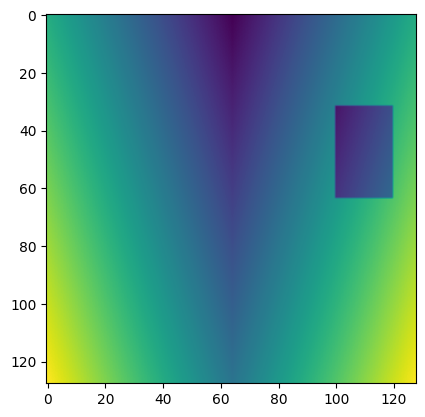

In [16]:
plt.imshow(DEM)

C:\Users\tsiokano\AppData\Local\Temp\ipykernel_12452\4239486998.py:58: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  edt_distances, edt_indices = scipy.ndimage.morphology.distance_transform_edt(


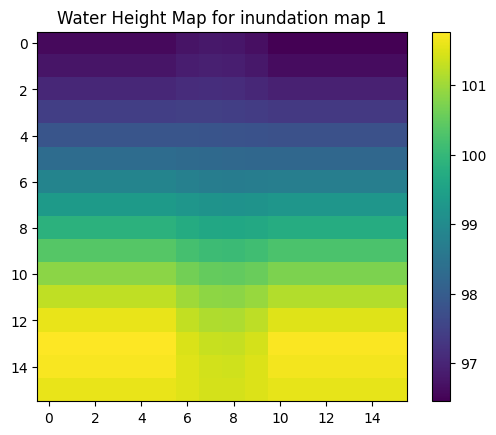

In [21]:
#@title Plot flood extent to depth output
height_raster = flood_extent_to_depth_solve(
    inundation_map=GROUND_TRUTH[2].ground_truth, 
    dem=DEM, 
    scale=20, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=8, 
        solve_iterations_factor=3.,
        force_coeff=0.1,
        drop_iterations=2,
        drop_coeff=0.1),
    force_tolerance=1, 
    force_local_region_width=5)

plt.title('Water Height Map for inundation map 1')
plt.imshow(height_raster)
plt.colorbar()
plt.show()

## The manifold model code

In [28]:
@dataclasses.dataclass
class _TrainExample:
  """Helper class for holding per-train-example data."""
  height_raster: np.ndarray
  gauge_level: float


class ManifoldModel:
    
  def __init__(self, dem: np.ndarray, scale: float,
               laplace_config: LaplaceDepthSolverConfig, 
               force_tolerance: float, 
               force_local_region_width: int,
               flood_agree_threshold: float) -> None:
    """Initializes a ManifoldModel object.

    Args:
      dem: A 2D array representing the DEM, in the shape of the ground truth
        images.
      scale: The scale of the DEM and the ground truth images.
      laplace_config: The Laplace solver config to use.
      force_tolerance: see `CatScanForceCalculator.tolerance`.
      force_local_region_width: see `CatScanForceCalculator.local_region_width`.
      agree_threshold: Used for the flood-fill algorithm. See 
        `flood_height_raster` for more details.
    """
    self.dem = dem
    self.scale = scale
    self.laplace_config = laplace_config
    self.force_tolerance = force_tolerance
    self.force_local_region_width = force_local_region_width
    self.flood_agree_threshold = flood_agree_threshold
    self.thresholding_model = ThresholdingModel()

  def train(self, ground_truth: Sequence[GroundTruthMeasurement]):
    print("Training an inner thresholding model used for flood-fill.")
    self.thresholding_model.train(ground_truth)
    
    print("Running flood extent to depth on ground truth examples..")
    sorted_ground_truth = sorted(ground_truth, 
                                 key=lambda gt: gt.gauge_measurement)
    self._train_examples = []
    for gt in sorted_ground_truth:
      gauge_level = gt.gauge_measurement
      print('Running flood extent to depth algorithm for image at gauge_level',
            gauge_level)
      height_raster = flood_extent_to_depth_solve(gt.ground_truth,
                                                  self.dem,
                                                  self.scale,
                                                  self.laplace_config,
                                                  self.force_tolerance,
                                                  self.force_local_region_width)
      self._train_examples.append(_TrainExample(height_raster=height_raster,
                                                gauge_level=gauge_level))
      
  def _interpolate_between(self, level: float, example_below: _TrainExample,
                           example_above: _TrainExample) -> np.ndarray:
    """Linearly interpolates between two train examples.

    Performs the piecewise linear interpolation on the train examples.

    Args:
      level: The gauge level to be used.
      example_below: The train example which is closest to `level` from below.
      example_above: The train example which is closest to `level` from above.

    Returns:
      The water height raster which is the linear interpolation between the
      provided train examples.
    """
    level_below = example_below.gauge_level
    level_above = example_above.gauge_level
    level_ratio = (level - level_below) / (level_above - level_below)
    return (level_ratio * example_above.height_raster +
            (1 - level_ratio) * example_below.height_raster)

  def _infer_piecewise_linear_manifold(self, gauge_level: float) -> np.ndarray:
    """Infers piecewise linear water height manifold given gauge level.

    The method performs piecewise linear interpolation between the saved train
    examples.

    Args:
      gauge_level: The gauge level to infer for.

    Returns:
      The inferred low-resolution water height manifold.
    """
    train_levels = [example.gauge_level for example in self._train_examples]
    index = np.searchsorted(train_levels, gauge_level)

    if index == 0:
      # Lower than train event.
      lowest_example = self._train_examples[0]
      return lowest_example.height_raster

    elif index == len(train_levels):
      # Extreme event.
      highest_example = self._train_examples[-1]
      # Create a new height raster by adding the difference between the current
      # measurement and the (previous) highest measurement to the height raster
      # of the (previous) highest measurement.
      return highest_example.height_raster + (gauge_level - train_levels[-1])
    else:
      return self._interpolate_between(
          level=gauge_level,
          example_below=self._train_examples[index - 1],
          example_above=self._train_examples[index])

  def infer(self, gauge_level: float):
    reference_inundation_map = self.thresholding_model.infer(gauge_level)
    manifold = self._infer_piecewise_linear_manifold(gauge_level)
    return flood_height_raster(interpolated_height_raster=manifold, 
                               dem=self.dem,
                               inundation_map=reference_inundation_map,
                               agree_threshold=self.flood_agree_threshold)

## Test code with dummy dataset

In [29]:
m = ManifoldModel(
    dem=DEM, 
    scale=100, 
    laplace_config=LaplaceDepthSolverConfig(
        down_scale_factor=8, 
        solve_iterations_factor=3.,
        force_coeff=0.9,
        drop_iterations=1,
        drop_coeff=0.00003),
    force_tolerance=1, 
    force_local_region_width=5,
    flood_agree_threshold=0.1)

m.train(GROUND_TRUTH)

Training an inner thresholding model used for flood-fill.


C:\Users\tsiokano\AppData\Local\Temp\ipykernel_12452\1027469096.py:213: RuntimeWarning: divide by zero encountered in divide
  ratios = true_wets / false_wets
C:\Users\tsiokano\AppData\Local\Temp\ipykernel_12452\1027469096.py:213: RuntimeWarning: invalid value encountered in divide
  ratios = true_wets / false_wets


For min_ratio=0.1 we get f1=0.9175276584072414
For min_ratio=0.3 we get f1=0.9175276584072414
For min_ratio=0.5 we get f1=0.9175276584072414
For min_ratio=1 we get f1=0.9359175662414132
For min_ratio=2 we get f1=0.9309214006135618
For min_ratio=5 we get f1=0.926336061627347
For min_ratio=10 we get f1=0.926336061627347
For min_ratio=15 we get f1=0.926336061627347
For min_ratio=20 we get f1=0.926336061627347
chosen min_ratio 1
Running flood extent to depth on ground truth examples..
Running flood extent to depth algorithm for image at gauge_level 1
Running flood extent to depth algorithm for image at gauge_level 2
Running flood extent to depth algorithm for image at gauge_level 3


C:\Users\tsiokano\AppData\Local\Temp\ipykernel_12452\4239486998.py:58: DeprecationWarning: Please import `distance_transform_edt` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  edt_distances, edt_indices = scipy.ndimage.morphology.distance_transform_edt(


### Manifold interpolation example

It can be seen that the manifold model is able to produce not only the flood extent, but rather the water depth at every pixel.

Moreover, the model is able to interpolate between training gauge levels. Below, one can see that the manifold model was able to create a water depth image for gauge level of 1.5, which did not exist during training.

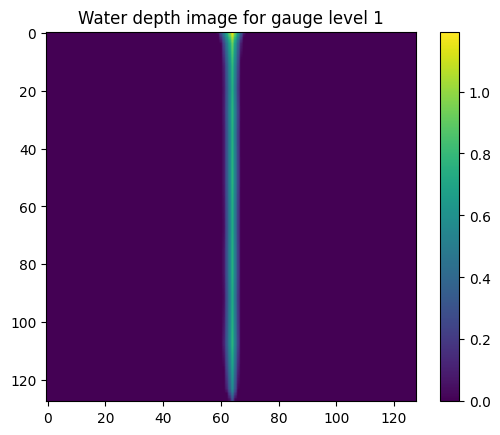

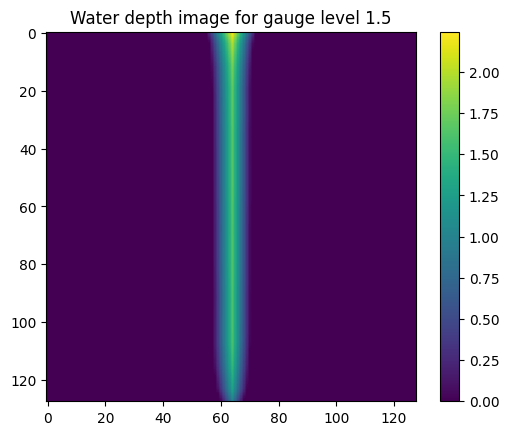

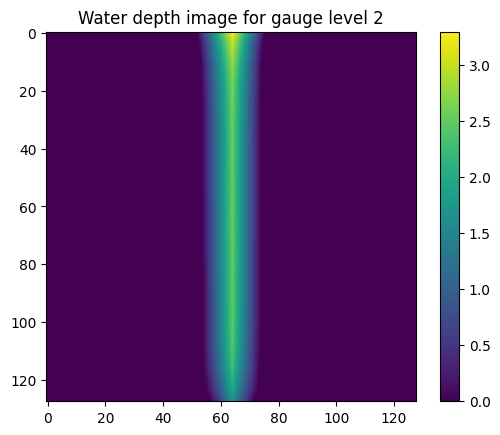

In [26]:
for gauge_level in [1, 1.5, 2]:
    plt.title(f'Water depth image for gauge level {gauge_level}')
    plt.imshow(m.infer(gauge_level))
    plt.colorbar()
    plt.show()

### Manifold extrapolation example

In addition, for unprecedented gauge levels, the model is able to extrapolate according to the DEM. For example, for gauge level of 7, the model floods the pool that exists in the DEM.

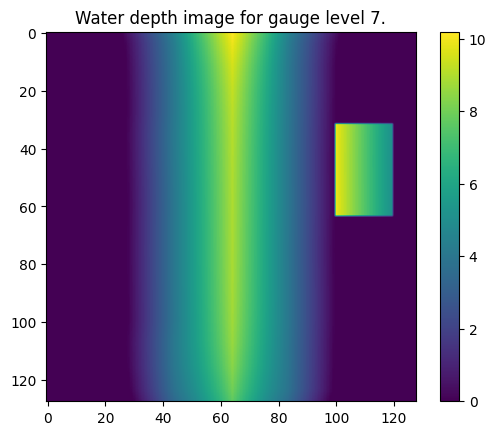

In [27]:
plt.title(f'Water depth image for gauge level 7.')
plt.imshow(m.infer(7.))
plt.colorbar()
plt.show()